<a href="https://colab.research.google.com/github/riotamoriya/kaggle/blob/main/tablar_nov_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Set the environment
%matplotlib inline

import seaborn as sns
import sys
import csv
import datetime
import operator
import joblib
import warnings
from pathlib import Path


warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew, probplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import StratifiedKFold

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

     |████████████████████████████████| 82 kB 378 kB/s 


In [2]:
if 'google.colab' in sys.modules:  # colab環境
    INPUT = Path('/content/input/')
elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    INPUT = Path('../input/')


from requests import get
name_notebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
print(name_notebook)


from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_emwa/kaggle.json ~/.kaggle
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
# !kaggle competitions list

tablar-nov-2021%5Banalysis%5D.ipynb
Mounted at /content/drive
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=9a82efde04ac12e7ca00ea98043add9de854e241a4c022c44141f0a8aa2356de
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
tryproblem = 'tabular-playground-series-nov-2021'
tryproblem += '.zip'

!kaggle competitions download -c tabular-playground-series-nov-2021
import zipfile
with zipfile.ZipFile(tryproblem) as existing_zip:
    existing_zip.extractall('.')

df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

 97% 417M/428M [00:04<00:00, 98.8MB/s]
100% 428M/428M [00:04<00:00, 93.1MB/s]


In [17]:
from sklearn.model_selection import train_test_split

# seed値
random_state_val =42
# validation に使うデータ数は20% <- hold out法
val_size=0.2
train,validation = train_test_split(df_train, test_size=val_size, random_state=random_state_val)

In [20]:
y_nm = 'target'

# 特徴量と目的変数とで分割
df_train_x = train.drop(y_nm, axis = 1)
df_train_y = pd.DataFrame(train[y_nm])

df_val_x = validation.drop(y_nm, axis = 1)
df_val_y = pd.DataFrame(validation[y_nm])

# テストデータは最初から特徴量しか入っていない。
# 命名規則を保つための代入
df_test_x = df_test

In [21]:
# 数値変数とカテゴリ変数が何か調べて分割
num_cols = [col for col in df_train_x.columns if df_train_x[col].dtype in ["float16","float32","float64"]]
cat_cols = [col for col in df_train_x.columns if df_train_x[col].dtype not in ["float16","float32","float64"]]

In [31]:
# 目的変数をコピー
y = train["target"].copy()

# カテゴリ変数全てにたいして（今回はIDのみ）
for cols in cat_cols:
    # カテゴリ変数の変換に、target encodingを用いている
    enc = TargetEncoder(cols=[cols])
    # IDというユニーク列への変換は意味ある？ 
    df_train_x = enc.fit_transform(df_train_x, y)
    df_val_x = enc.transform(df_val_x)
    df_test_x = enc.transform(df_test_x)

In [47]:
# 学習データに基づいて標準化
# 手法としてはRankGaussを用いている
scaler = QuantileTransformer()
scaler.fit(df_train_x)

# 変換後のデータで各列を置換
df_train_x = pd.DataFrame(scaler.transform(df_train_x))
df_val_x = pd.DataFrame(scaler.transform(df_val_x))
df_test_x = pd.DataFrame(scaler.transform(df_test_x))

In [50]:
XGBClassifier = xgb.XGBClassifier(max_depth = 8, # 決定技の深さ
                                 learning_rate = 0.005, # 学習率
                                 n_estimators = 10000, # boost 回数
                                 objective = 'binary:logistic',
                                 tree_method = 'gpu_hist',
                                 booster = 'gbtree',
                                 gamma = 0.64, 
                                 max_delta_step = 3,
                                 min_child_weight = 7,
                                 subsample = 0.7,
                                 colsample_bytree = 0.8,
                                 n_jobs = -1
                                 )

In [51]:
start = datetime.datetime.now()
xgb = XGBClassifier.fit(df_train_x.values, # 特徴量
                       df_train_y.values.ravel(),　# 正解ラベル
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)], # 評価は学習データとバリデーションデータ
                       eval_metric = 'auc', # 目的関数にはAUC(今回の評価基準)を設定
                       early_stopping_rounds = 15, # 15を基準に早く切る
                       verbose = True) # 出力の設定
end = datetime.datetime.now()
end-start
# 3393s = 57m

ストリーミング出力は最後の 5000 行に切り捨てられました。
[309]	validation_0-auc:0.735574	validation_1-auc:0.706511
[310]	validation_0-auc:0.735678	validation_1-auc:0.706584
[311]	validation_0-auc:0.735795	validation_1-auc:0.706668
[312]	validation_0-auc:0.735884	validation_1-auc:0.706728
[313]	validation_0-auc:0.735962	validation_1-auc:0.706776
[314]	validation_0-auc:0.736091	validation_1-auc:0.706866
[315]	validation_0-auc:0.736171	validation_1-auc:0.706931
[316]	validation_0-auc:0.736285	validation_1-auc:0.707017
[317]	validation_0-auc:0.736421	validation_1-auc:0.70711
[318]	validation_0-auc:0.736502	validation_1-auc:0.707152
[319]	validation_0-auc:0.736599	validation_1-auc:0.70722
[320]	validation_0-auc:0.736685	validation_1-auc:0.707272
[321]	validation_0-auc:0.736755	validation_1-auc:0.707321
[322]	validation_0-auc:0.736816	validation_1-auc:0.70737
[323]	validation_0-auc:0.736934	validation_1-auc:0.707463
[324]	validation_0-auc:0.737028	validation_1-auc:0.707524
[325]	validation_0-auc:0.7371	validation_1-

datetime.timedelta(seconds=3393, microseconds=169584)

In [115]:
# 全ての木の分岐で、特徴量ごとにいくつ使われたか
fi_vals = xgb.get_booster().get_score(importance_type = 'weight')
# fi_vals(dict)をkeyの数字によってソート
fi_dict = {df_train_x.columns[i]:float(fi_vals.get('f'+str(i),0.)) for i in range(len(df_train_x.columns))}
# value によってソート
feature_importance_ = sorted(fi_vals.items(), key=operator.itemgetter(1), reverse=True)
# Dict -> Ordered dict
feature_importance_result = OrderedDict(feature_importance_)
importance = pd.DataFrame(feature_importance_)
importance.columns = ['feature','weight']
### 分岐に貢献した順に特徴量がpdに表された
importance.head(10)

,feature,weight
0,f9,15032
1,f81,14691
2,f28,14536
3,f51,14424
4,f72,14333
5,f98,14218
6,f92,14176
7,f35,14154
8,f56,14117
9,f42,14025


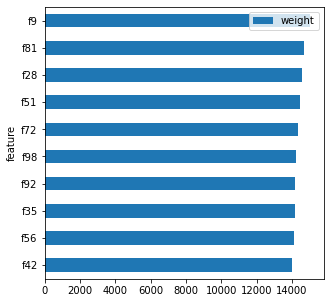

In [118]:
# ランキング10位を可視化
importance_ten = importance[:10]
importance_ten.set_index('feature').sort_values(by='weight').plot(kind='barh', figsize=(5, 5))

In [157]:
val_y_prob

array([0.57691973, 0.5970089 , 0.5553674 , ..., 0.5888989 , 0.6287394 ,
       0.61118007], dtype=float32)

In [163]:
result_lst

[{'Threshold': 0.01, 'Accuracy': 0.5073, 'Precision': 0.5073, 'Recall': 1.0, 'F1_Score': 0.6732, 'roc_auc': 0.7484, 'Kappa': 0.0}, {'Threshold': 0.02, 'Accuracy': 0.5073, 'Precision': 0.5073, 'Recall': 1.0, 'F1_Score': 0.6732, 'roc_auc': 0.7484, 'Kappa': 0.0}, {'Threshold': 0.03, 'Accuracy': 0.5073, 'Precision': 0.5073, 'Recall': 1.0, 'F1_Score': 0.6732, 'roc_auc': 0.7484, 'Kappa': 0.0}, {'Threshold': 0.04, 'Accuracy': 0.5073, 'Precision': 0.5073, 'Recall': 1.0, 'F1_Score': 0.6732, 'roc_auc': 0.7484, 'Kappa': 0.0}, {'Threshold': 0.05, 'Accuracy': 0.5074, 'Precision': 0.5074, 'Recall': 1.0, 'F1_Score': 0.6732, 'roc_auc': 0.7484, 'Kappa': 0.0001}, {'Threshold': 0.06, 'Accuracy': 0.5075, 'Precision': 0.5074, 'Recall': 0.9999, 'F1_Score': 0.6732, 'roc_auc': 0.7484, 'Kappa': 0.0003}, {'Threshold': 0.07, 'Accuracy': 0.5077, 'Precision': 0.5075, 'Recall': 0.9997, 'F1_Score': 0.6732, 'roc_auc': 0.7484, 'Kappa': 0.0007}, {'Threshold': 0.08, 'Accuracy': 0.5081, 'Precision': 0.5077, 'Recall': 0.9

In [ ]:
result_lst =[]
max_roc_auc =0.
opt_threshold =0.
val_y_prob = xgb.predict_proba(df_val_x.values)[:, 1]

# バリデーションデータのROC曲線を計算
fpr, tpr, _ = roc_curve(df_val_y, val_y_prob)
# AUCを計算
roc_auc = auc(fpr, tpr)

cnt = 1
cnt2 = 1
for n in range(0,50):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    # 0.01ごとにずらした閾値より大きければ1
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    # 各評価指標を計算
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4),'roc_auc': round(roc_auc,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    print(cnt2)
    cnt2 += 1
    if max_roc_auc <= roc_auc: # roc_aucが更新されていないため全てがTrue
        max_roc_auc = roc_auc
        opt_threshold = threshold
        print(cnt)
        cnt += 1
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score','roc_auc' ,'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('Max roc_auc =%f, optimized_threshold=%f'%(max_roc_auc, opt_threshold))
print('Complete')

In [57]:
predict_xgb = xgb.predict_proba(df_train_x.values)[:,1]
pred_train = np.where(predict_xgb > opt_threshold, 1., 0.)

# 混合行列の計算
tp, fn, fp, tn = confusion_matrix(df_train_y.values.ravel(), pred_train, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_train_y.values.ravel(), pred_train),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_train_y.values.ravel(), pred_train))

1. Counfusion Matrix
                   True Value 0  True Value 1
Predicted Value 0        186727         47539
Predicted Value 1         50548        195186

2. Classification Report
              precision    recall  f1-score   support

           0       0.80      0.79      0.79    237275
           1       0.79      0.80      0.80    242725

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000



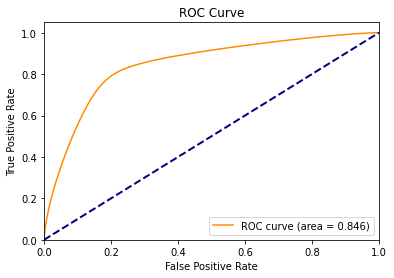

In [58]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_train_y.values.ravel(), predict_xgb)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [59]:
pred_test = xgb.predict_proba(df_test_x.values)[:,1]

test_result= pd.DataFrame(pred_test)
test_result.columns = ['target']
predict = test_result['target']
Id_No = df_test['id']
submission = pd.DataFrame({'id': Id_No, 'target': predict})
submission['target'] = submission['target'].astype('float32')
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,600000,0.660959
1,600001,0.560217
2,600002,0.808851
3,600003,0.535137
4,600004,0.502644


In [61]:
!kaggle competitions submit -c tabular-playground-series-nov-2021 -f submission.csv -m 'first submit'

100% 9.16M/9.16M [00:02<00:00, 4.50MB/s]
Successfully submitted to Tabular Playground Series - Nov 2021